<a href="https://colab.research.google.com/github/jack-cao-623/peloton_workouts/blob/main/peloton_workouts_jcao623_thru_2024_11_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# packages to install
install.packages("RCurl")
install.packages("janitor")
install.packages("ggtext")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# packages needed
library(RCurl) # for reading in data
library(tidyverse) # for data wrangling and visualization
library(janitor)
library(ggtext)

In [ ]:
# get Peloton workout data
workout_data <- RCurl::getURL("https://raw.githubusercontent.com/jack-cao-623/peloton_workouts/refs/heads/main/jcao623_workouts_2024_11_23.csv")
df_raw <- readr::read_csv(workout_data)
head(df_raw, n = 3)

Rows: 1304 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Workout Timestamp, Live/On-Demand, Instructor Name, Length (minutes...
dbl (7): Total Output, Avg. Watts, Avg. Cadence (RPM), Avg. Speed (mph), Dis...
lgl (2): Avg. Incline, Avg. Pace (min/mi)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Workout Timestamp,Live/On-Demand,Instructor Name,Length (minutes),Fitness Discipline,Type,Title,Class Timestamp,Total Output,Avg. Watts,Avg. Resistance,Avg. Cadence (RPM),Avg. Speed (mph),Distance (mi),Calories Burned,Avg. Heartrate,Avg. Incline,Avg. Pace (min/mi)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
2022-01-16 07:36 (PST),On Demand,Andy Speer,30,Strength,Upper Body,30 min Upper Body Strength,2022-01-10 10:23 (PST),NA,NA,NA,NA,NA,NA,149,NA,NA,NA
2022-01-17 08:13 (PST),On Demand,Olivia Amato,5,Stretching,Post-Run Stretch,5 min Post-Run Stretch,2022-01-07 07:00 (PST),NA,NA,NA,NA,NA,NA,12,NA,NA,NA
2022-01-20 07:06 (PST),On Demand,Rad Lopez,20,Strength,Upper Body,20 min Arms & Shoulders Strength,2022-01-19 05:20 (PST),NA,NA,NA,NA,NA,NA,100,NA,NA,NA


In [ ]:
# data cleaning

df_tidy <- df_raw %>%

    # column names to lower case, numeric, and replace spaces with underscores
    janitor::clean_names() %>%

    # new columns for anlaysis
    dplyr::mutate(

      # date of workout, e.g., 2024-11-04
      workout_date = lubridate::ymd(stringr::str_sub(workout_timestamp, start = 1, end = 10))

      # month of workout; first day of month, e.g., 2024-11-01
      , workout_month = lubridate::floor_date(workout_date, 'month')

      # day of week for workout, e.g., Sun
      , workout_day_of_week = lubridate::wday(workout_date, label = TRUE)

      # hour of workout, e.g., 07
      , workout_hour = stringr::str_sub(workout_timestamp, start = 12, end = 13)

      # (PST) means Pacific Time; unclear what (-08) and (-07) mean...when Apple watch is connected?
      , workout_timezone = stringr::str_sub(workout_timestamp, start = -5)

      # convert lenght of workout in minutes from string to numeric
      , length_minutes = base::as.numeric(length_minutes)

    )

Warning message:
“There was 1 warning in `dplyr::mutate()`.
ℹ In argument: `length_minutes = base::as.numeric(length_minutes)`.
Caused by warning:
! NAs introduced by coercion”


In [ ]:
head(df_tidy, n = 3)

workout_timestamp,live_on_demand,instructor_name,length_minutes,fitness_discipline,type,title,class_timestamp,total_output,avg_watts,⋯,distance_mi,calories_burned,avg_heartrate,avg_incline,avg_pace_min_mi,workout_date,workout_month,workout_day_of_week,workout_hour,workout_timezone
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<date>,<date>,<ord>,<chr>,<chr>
2022-01-16 07:36 (PST),On Demand,Andy Speer,30,Strength,Upper Body,30 min Upper Body Strength,2022-01-10 10:23 (PST),NA,NA,⋯,NA,149,NA,NA,NA,2022-01-16,2022-01-01,Sun,07,(PST)
2022-01-17 08:13 (PST),On Demand,Olivia Amato,5,Stretching,Post-Run Stretch,5 min Post-Run Stretch,2022-01-07 07:00 (PST),NA,NA,⋯,NA,12,NA,NA,NA,2022-01-17,2022-01-01,Mon,08,(PST)
2022-01-20 07:06 (PST),On Demand,Rad Lopez,20,Strength,Upper Body,20 min Arms & Shoulders Strength,2022-01-19 05:20 (PST),NA,NA,⋯,NA,100,NA,NA,NA,2022-01-20,2022-01-01,Thu,07,(PST)


In [ ]:
# favorite instructor

df_favorite_instructor <- df_tidy %>%

    # exclude Yoga
    dplyr::filter(fitness_discipline != "Yoga") %>%

    # number of workouts per instructor per discipline per month
    dplyr::group_by(instructor_name, fitness_discipline, workout_month) %>%
    dplyr::summarise(num_workouts = dplyr::n()) %>%
    dplyr::ungroup() %>%

    # make missing rows explicit; e.g., some months didn't have any workouts by a certain instructor
    dplyr::arrange(instructor_name, fitness_discipline, workout_month) %>%
    tidyr::complete(instructor_name, fitness_discipline, workout_month, fill = list(num_workouts = 0)) %>%
    dplyr::arrange(instructor_name, fitness_discipline, workout_month) %>%

    # cumulative workout count for each instructor and discipline across months
    dplyr::group_by(instructor_name, fitness_discipline) %>%
    dplyr::mutate(
      cumulative_workouts = base::cumsum(num_workouts)
    ) %>%

    # for plot labels instead of legend; too many instructors
    dplyr::mutate(
      instructor_label = dplyr::case_when(
        workout_month == as.Date("2024-11-01") ~ instructor_name
        , TRUE ~ NA_character_
      )
    )

`summarise()` has grouped output by 'instructor_name', 'fitness_discipline'.
You can override using the `.groups` argument.


Warning message:
“Removed 1633 rows containing missing values or values outside the scale range
(`geom_rich_text()`).”


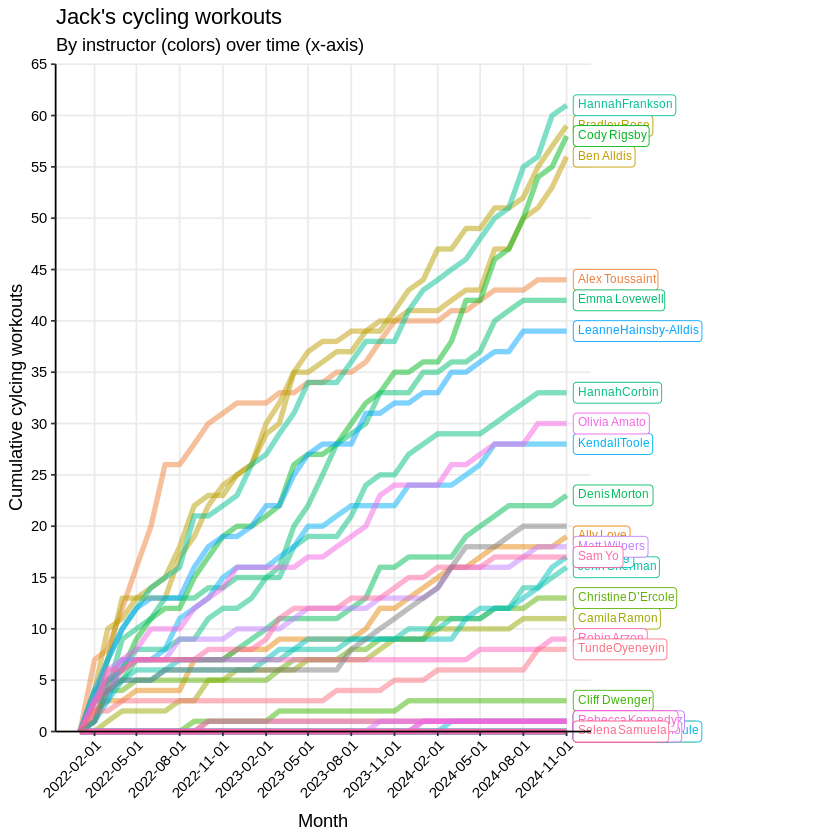

In [ ]:
# most frequent instructors
df_favorite_instructor %>%
    dplyr:::filter(
      fitness_discipline == "Cycling"
    ) %>%
    dplyr::mutate(instructor_name = forcats::fct_drop(instructor_name)) %>%
    ggplot(
      mapping = aes(
        x = workout_month, y = cumulative_workouts, color = instructor_name, group = instructor_name
      )
    ) +
    geom_line(lwd = 1.5, alpha = 0.5) +
    geom_richtext(mapping = aes(label = instructor_label)
                  , label.margin = unit(4, "pt"),
                  , label.padding = unit(3, "pt"),
                  , hjust = 0
                  , show.legend = FALSE
                  , size = 2.5
                 ) +
    coord_cartesian(clip = "off", ylim = c(0, 65)) +
    scale_x_date(breaks = "3 months") +
    scale_y_continuous(breaks = seq(0, 65, 5), expand = c(0, 0)) +
    guides(color = "none") +
    labs(
      x = "Month"
      , y = "Cumulative cylcing workouts"
      , title = "Jack's cycling workouts"
      , subtitle = "By instructor (colors) over time (x-axis)"
    ) +
    theme_bw() +
    theme(
      plot.margin = margin(5.5, 150, 5.5, 5.5)
      , axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
      , panel.grid.minor = element_blank()
      , panel.border = element_blank()
      , axis.line = element_line(color = "black")
      , axis.text = element_text(color = "black")
    )


Warning message:
“Removed 1633 rows containing missing values or values outside the scale range
(`geom_rich_text()`).”


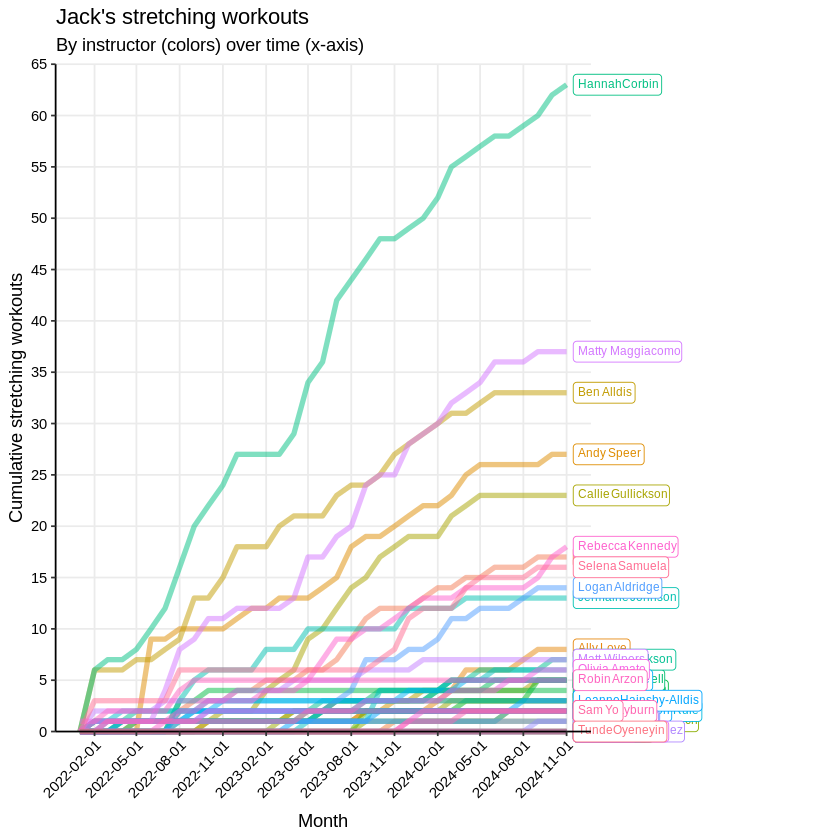

In [ ]:
# most frequent instructors
df_favorite_instructor %>%
    dplyr:::filter(
      fitness_discipline == "Stretching"
    ) %>%
    dplyr::mutate(instructor_name = forcats::fct_drop(instructor_name)) %>%
    ggplot(
      mapping = aes(
        x = workout_month, y = cumulative_workouts, color = instructor_name, group = instructor_name
      )
    ) +
    geom_line(lwd = 1.5, alpha = 0.5) +
    geom_richtext(mapping = aes(label = instructor_label)
                  , label.margin = unit(4, "pt"),
                  , label.padding = unit(3, "pt"),
                  , hjust = 0
                  , show.legend = FALSE
                  , size = 2.5
                 ) +
    coord_cartesian(clip = "off", ylim = c(0, 65)) +
    scale_x_date(breaks = "3 months") +
    scale_y_continuous(breaks = seq(0, 65, 5), expand = c(0, 0)) +
    guides(color = "none") +
    labs(
      x = "Month"
      , y = "Cumulative stretching workouts"
      , title = "Jack's stretching workouts"
      , subtitle = "By instructor (colors) over time (x-axis)"
    ) +
    theme_bw() +
    theme(
      plot.margin = margin(5.5, 150, 5.5, 5.5)
      , axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
      , panel.grid.minor = element_blank()
      , panel.border = element_blank()
      , axis.line = element_line(color = "black")
      , axis.text = element_text(color = "black")
    )


Warning message:
“Removed 1633 rows containing missing values or values outside the scale range
(`geom_rich_text()`).”


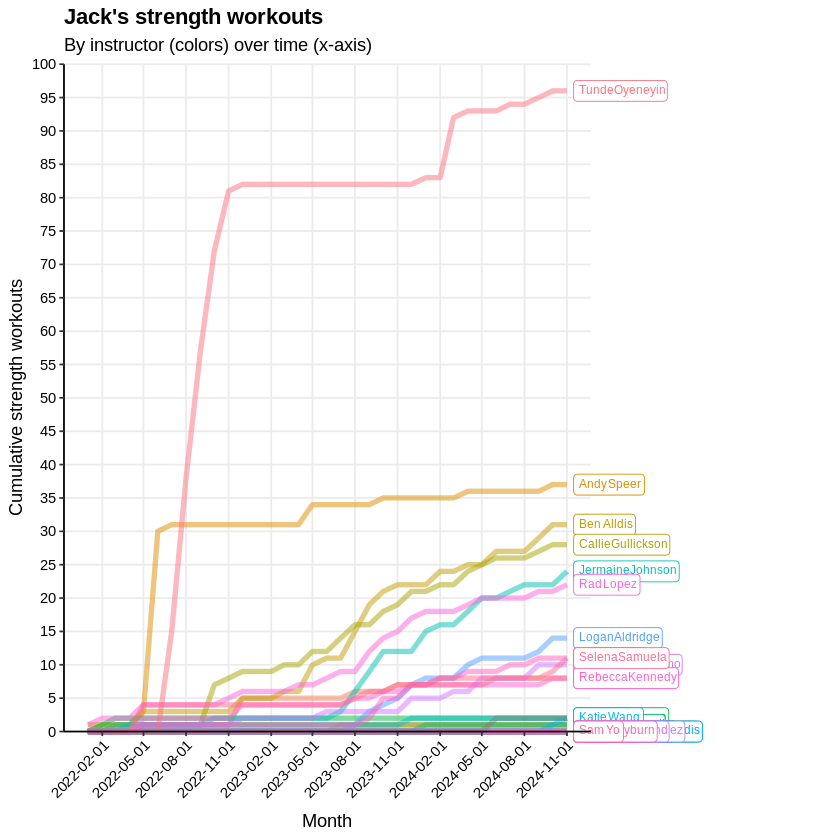

In [ ]:
# most frequent instructors
df_favorite_instructor %>%
    dplyr:::filter(
      fitness_discipline == "Strength"
    ) %>%
    dplyr::mutate(instructor_name = forcats::fct_drop(instructor_name)) %>%
    ggplot(
      mapping = aes(
        x = workout_month, y = cumulative_workouts, color = instructor_name, group = instructor_name
      )
    ) +
    geom_line(lwd = 1.5, alpha = 0.5) +
    geom_richtext(mapping = aes(label = instructor_label)
                  , label.margin = unit(4, "pt"),
                  , label.padding = unit(3, "pt"),
                  , hjust = 0
                  , show.legend = FALSE
                  , size = 2.5
                 ) +
    coord_cartesian(clip = "off", ylim = c(0, 100)) +
    scale_x_date(breaks = "3 months") +
    scale_y_continuous(breaks = seq(0, 100, 5), expand = c(0, 0)) +
    guides(color = "none") +
    labs(
      x = "Month"
      , y = "Cumulative strength workouts"
      , title = "Jack's strength workouts"
      , subtitle = "By instructor (colors) over time (x-axis)"
    ) +
    theme_bw() +
    theme(
      plot.margin = margin(5.5, 150, 5.5, 5.5)
      , axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)
      , panel.grid.minor = element_blank()
      , panel.border = element_blank()
      , axis.line = element_line(color = "black")
      , axis.text = element_text(color = "black")
      , plot.title = element_text(face = "bold")
    )


In [ ]:
# when do you workout?

df_tidy %>%
    dplyr::filter(fitness_discipline != "Yoga") %>%
    dplyr::group_by(fitness_discipline, workout_day_of_week, workout_hour) %>%
    dplyr::summarise(num_workouts = dplyr::n()) %>%
    dplyr::ungroup() %>%
    tidyr::complete(fitness_discipline, workout_day_of_week, workout_hour, fill = list(num_workouts = 0)) %>%
    dplyr::ungroup()

`summarise()` has grouped output by 'fitness_discipline',
'workout_day_of_week'. You can override using the `.groups` argument.


fitness_discipline,workout_day_of_week,workout_hour,num_workouts
<chr>,<ord>,<chr>,<int>
Cycling,Sun,04,0
Cycling,Sun,05,0
Cycling,Sun,06,1
Cycling,Sun,07,11
Cycling,Sun,08,27
Cycling,Sun,09,10
Cycling,Sun,10,8
Cycling,Sun,11,5
Cycling,Sun,12,6


`summarise()` has grouped output by 'fitness_discipline',
'workout_day_of_week'. You can override using the `.groups` argument.


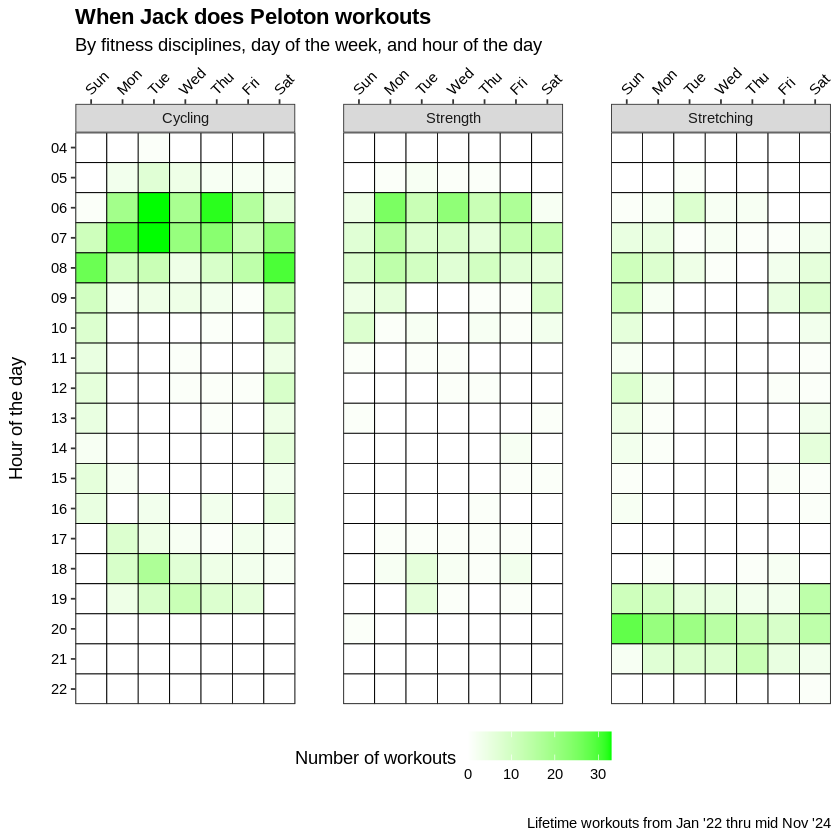

In [ ]:
# when do you workout?

df_tidy %>%
    dplyr::filter(fitness_discipline != "Yoga") %>%
    dplyr::group_by(fitness_discipline, workout_day_of_week, workout_hour) %>%
    dplyr::summarise(num_workouts = dplyr::n()) %>%
    dplyr::ungroup() %>%
    tidyr::complete(fitness_discipline, workout_day_of_week, workout_hour, fill = list(num_workouts = 0)) %>%
    dplyr::ungroup() %>%
    ggplot(mapping = aes(x = workout_day_of_week, y = workout_hour, fill = num_workouts)) +
    facet_grid(~fitness_discipline) +
    geom_tile(color = "black", lwd = 0.25) +
    #scale_fill_viridis_c() +
    scale_fill_gradient2(
      low = "white"
      , high = "green"
    ) +
    scale_x_discrete(position = "top", expand = c(0, 0)) +
    scale_y_discrete(limits = rev, expand = c(0, 0)) +
    labs(
      title = "When Jack does Peloton workouts"
      , subtitle = "By fitness disciplines, day of the week, and hour of the day"
      , y = "Hour of the day\n", x = NULL
      , fill = "Number of workouts"
      , caption = "\nLifetime workouts from Jan '22 thru mid Nov '24"
    ) +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 0, vjust = 0)
      , axis.text = element_text(color = "black")
      , legend.position = "bottom"
      , legend.direction = "horizontal"
      , plot.title = element_text(face = "bold")
      , panel.spacing = unit(2, "lines")
    )